# Train and test datasets

Now that we've decided we're going to use a machine learning approach, we need to come up with train and test datasets on which we can build, and then evaluate a model.

### Positive examples

The tricky thing when working with graph data is that we can't just randomly split the data, as this could lead to data leakage.

Data leakage can occur when data outside of your training data is inadvertently used to create your model. This can easily happen when working with graphs because pairs of nodes in our training set may be connected to those in the test set.

When we compute link prediction measures over that training set the __measures computed contain information from the test set__ that we’ll later evaluate our model against.

Instead we need to split our graph into training and test sub graphs. If our graph has a concept of time our life is easy — we can split the graph at a point in time and the training set will be from before the time, the test set after.

This is still not a perfect solution and we’ll need to try and ensure that the general network structure in the training and test sub graphs is similar.

Once we’ve done that we’ll have pairs of nodes in our train and test set that have relationships between them. They will be the __positive examples__ in our machine learning model.

We are lucky that our citation graph contains a times. We can create train and test graphs by splitting the data on a particular year. Now we need to figure out what year that should be. Let's have a look at the distribution of the first year that co-authors collaborated:

In [54]:
from neo4j import GraphDatabase

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [55]:
bolt_uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(bolt_uri, auth=("neo4j", "neo4jneo4j"))

print(driver.address)

localhost:7687


We can create the co-author graph by running the query below to do this:

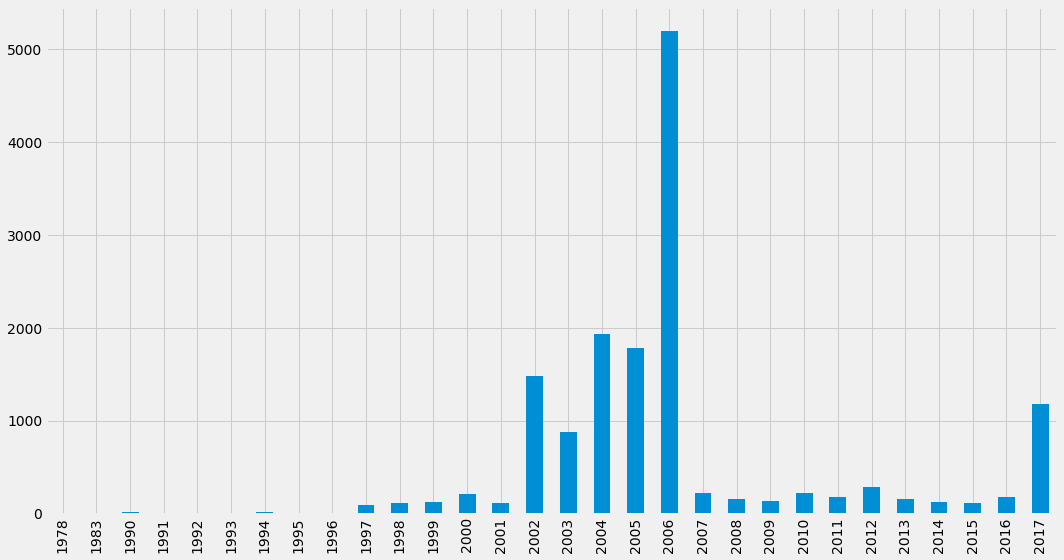

In [56]:
query = """
MATCH p=()-[r:CO_AUTHOR]->()
WITH r.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""

with driver.session(database="demo") as session:
    result = session.run(query)
    by_year = pd.DataFrame([dict(record) for record in result])

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()

plt.show()

It looks like 2006 would act as a good year on which to split the data. We'll take all the co-authorships from 2005 and earlier as our train graph, and everything from 2006 onwards as the test graph.

Let's create explicit `CO_AUTHOR_EARLY` and `CO_AUTHOR_LATE` relationships in our graph based on that year. The following code will create these relationships for us:

In [57]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b)
where r.year < 2006
MERGE (a)-[:CO_AUTHOR_EARLY {year: r.year}]-(b);
"""

with driver.session(database="demo") as session:
    display(session.run(query).consume().counters)

query = """
MATCH (a)-[r:CO_AUTHOR]->(b)
where r.year >= 2006
MERGE (a)-[:CO_AUTHOR_LATE {year: r.year}]-(b);
"""

with driver.session(database="demo") as session:
    display(session.run(query).consume().counters)

{'_contains_updates': True, 'relationships_created': 6801, 'properties_set': 6801}

{'_contains_updates': True, 'relationships_created': 8144, 'properties_set': 8144}

Let's quickly check how many co-author relationship we have in each of these sub graphs:

In [58]:
query = """
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) AS count
"""

with driver.session(database="demo") as session:
    result = session.run(query)
    df = pd.DataFrame([dict(record) for record in result])
df

,count
0,6801


In [59]:
query = """
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) AS count
"""

with driver.session(database="demo") as session:
    result = session.run(query)
    df = pd.DataFrame([dict(record) for record in result])
df

,count
0,8144


### Negative examples

The simplest approach would be to use all pair of nodes that don’t have a relationship. __The problem with this approach is that there are significantly more examples of pairs of nodes that don’t have a relationship than there are pairs of nodes that do__.

The maximum number of negative examples is equal to:

```
# negative examples = (# nodes)² - (# relationships) - (# nodes)
```

i.e. the number of nodes squared, minus the relationships that the graph has, minus self relationships.

If we use all of these negative examples in our training set we will have a massive class imbalance — there are many negative examples and relatively few positive ones.

A model trained using data that’s this imbalanced will achieve very high accuracy by __predicting that any pair of nodes don’t have a relationship__ between them, which is not quite what we want!

So we need to try and reduce the number of negative examples. An approach described in several link prediction papers is to use pairs of nodes that are a __specific number of hops away from each other__.

This will significantly reduce the number of negative examples, although there will still be a lot more negative examples than positive.

To solve this problem we either need to down sample the negative examples or up sample the positive examples.

We're going to take the down sampling approach in this guide, and the following function will do this for us:

In [60]:
with driver.session(database="demo") as session:
    result = session.run("""
             MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
             RETURN id(author) AS node1, id(other) AS node2, 1 AS label""")
    train_existing_links = pd.DataFrame([dict(record) for record in result])

    result = session.run("""
             MATCH (author:Author)
             WHERE (author)-[:CO_AUTHOR_EARLY]-()
             MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
             WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
             RETURN id(author) AS node1, id(other) AS node2, 0 AS label""")
    train_missing_links = pd.DataFrame([dict(record) for record in result])    
    train_missing_links = train_missing_links.drop_duplicates()

In [61]:
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')

count_class_0, count_class_1 = training_df.label.value_counts()
print(f"Negative examples: {count_class_0}")
print(f"Positive examples: {count_class_1}")

df_class_0 = training_df[training_df['label'] == 0]
df_class_1 = training_df[training_df['label'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random downsampling:')
print(df_train_under.label.value_counts())

Negative examples: 13908
Positive examples: 6801
Random downsampling:
0    6801
1    6801
Name: label, dtype: int64


Let's now do the same thing for our test set:

In [62]:
with driver.session(database="demo") as session:
    result = session.run("""
             MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
             RETURN id(author) AS node1, id(other) AS node2, 1 AS label""")
    test_existing_links = pd.DataFrame([dict(record) for record in result])

    result = session.run("""
             MATCH (author:Author)
             WHERE (author)-[:CO_AUTHOR_LATE]-()
             MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
             WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
             RETURN id(author) AS node1, id(other) AS node2, 0 AS label""")
    test_missing_links = pd.DataFrame([dict(record) for record in result])    
    test_missing_links = test_missing_links.drop_duplicates()

In [63]:
# Compute positive and negative examples

test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')

count_class_0, count_class_1 = test_df.label.value_counts()
print(f"Negative examples: {count_class_0}")
print(f"Positive examples: {count_class_1}")


# Down sample the negative examples

df_class_0 = test_df[test_df['label'] == 0]
df_class_1 = test_df[test_df['label'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random downsampling:')
print(df_test_under.label.value_counts())

Negative examples: 16835
Positive examples: 8144
Random downsampling:
0    8144
1    8144
Name: label, dtype: int64


Before we move on, let's have a look at the contents of our train and test DataFrames:

In [64]:
df_train_under.sample(5, random_state=42)

,node1,node2,label
15822,3405,9308,1
19871,13035,13036,1
3461,4851,4851,0
6898,7040,7040,0
2401,2792,4923,0


In [65]:
df_test_under.sample(5, random_state=42)

,node1,node2,label
5734,5325,9589,0
12056,10195,10195,0
22268,9548,9567,1
3075,2696,2757,0
105,1040,3049,0


In [66]:
# Save our DataFrames to CSV files for use in the next notebook

df_train_under.to_csv("data/df_train_under.csv", index=False)
df_test_under.to_csv("data/df_test_under.csv", index=False)

# df_train_under = pd.read_csv("data/df_train_under.csv")
# df_test_under = pd.read_csv("data/df_test_under.csv")

df_train_under.sample(5, random_state=42).to_csv("data/df_train_under_basic_sample.csv", index=False)
df_test_under.sample(5, random_state=42).to_csv("data/df_test_under_basic_sample.csv", index=False)